<a href="https://colab.research.google.com/github/buceleasebastian/GAN/blob/main/src/DCGAN_CelebA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Deep Convolutional Generative Adversarial Networks

## Unzipping data and loading modules

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
my_path = '/Deep_Learning_Project/img_align_celeba'
gdrive_path = "/content/drive" + "/My Drive" + my_path

Mounted at /content/drive


In [ ]:
! cp -r /content/drive/MyDrive/Deep_Learning_Project/img_align_celeba.zip .

In [ ]:
! ls /content/drive/MyDrive/Deep_Learning_Project/img_align_celeba

ls: cannot open directory '/content/drive/MyDrive/Deep_Learning_Project/img_align_celeba': Input/output error


In [ ]:
%%capture
! unzip img_align_celeba.zip

In [ ]:
! mkdir celeba
! mv img_align_celeba celeba

In [ ]:
! mv img_align_celeba celeba

mv: cannot stat 'img_align_celeba': No such file or directory


In [ ]:
#Importing modules
import matplotlib.pyplot as plt
import torch
import random
import torchvision
import torchvision.utils as utils
import torch.nn as nn
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import matplotlib as plt
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.nn.modules.batchnorm import BatchNorm2d
from torch.nn.modules.conv import ConvTranspose2d


#Data Loading

In [ ]:
#Charing the datset : 
data = datasets.ImageFolder(root="/content/celeba", transform=ToTensor())


In [ ]:
#Attributing dataset to 
dataloader = DataLoader(data, batch_size=64, shuffle=True, num_workers=2)

#Parameter Initialization

## Image Parameters

In [ ]:
"""Generator and Discriminator hyperparameters

Parameters taken as arguments in the initialization of the Generator and Discriminator Network

Parameters

----------
n_channels : number of channels of the image, corresponds to the number of channel of the input for the discriminator and the output for the generator - set to 3 for an RGB image
size_latent : size of the latent noise vector taken as input for the Generator
disc_features : size of the feature maps passed as input for the discriminator
gen_features : size of feature maps (images obtained after applying the convolution) in the generator
image_size : size of each image
----------

References 

----------

  [1^]  [Radford A., Metz L. Chintala S. (2016) : Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks] (https://arxiv.org/abs/1511.06434)
  [2^]  [Inkawich, N - DCGAN Tutorial] (https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html)

"""

###Pure python code can be found here
### https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html


#device initialization
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

#Number of channels of the training images
n_channels = 3

#Size of the latent vector
size_latent = 100

#Discriminator feature maps size
disc_features = 64

#Generator feature maps size
gen_features = 64

#Image size 
image_size = 64


##Optimization parameters

In [ ]:
"""Optimization hyperparameters

Parameters taken as arguments during training 

Parameters

----------
batch_size : number of samples that 
lr : learning rate, dictates the pace at which the networks update the values of parameter estimates
beta1 and beta2 : initial decay rates for the Adam optimizer
epochs : number of times the network will pass through the entire dataset
----------

References 

----------

[1^]  [Radford A., Metz L. Chintala S. (2016) : Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks] (https://arxiv.org/abs/1511.06434)
[2^]  [Inkawich, N - DCGAN Tutorial] (https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html)


"""
###Pure python code can be found here
### https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

#Batch size
batch_size = 128

#Adam optimizer learning rate
lr = 0.0002

#Adam optimizer beta hyperparameters
beta1 = 0.5
beta2 = 0.999

#Number of training epochs
epochs = 3

#Data description

##Plotting some images from the datase

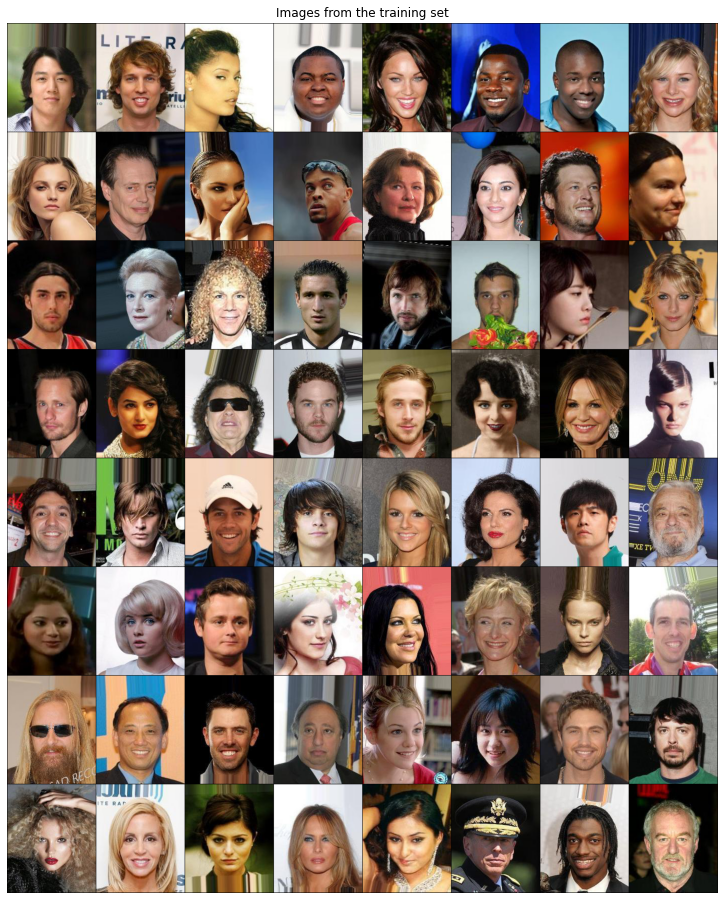

In [ ]:
batch = next(iter(dataloader))
plt.figure(figsize = (16,16))
plt.axis("off")
plt.title("Images from the training set")
plt.imshow(np.transpose(utils.make_grid(batch[0].to(device)[:64], padding = 1, normalize = True).cpu(),(1,2,0)))

#Generator and Discriminator

##Generator

In [ ]:
class Generator(nn.Module):

  """Generator class Network
  
  Class inherits from pytorch Neural Network Module
  We are taking the noise vector and then we are passing 2D Transposed Convolutional layers, that are paired with Batch Normalization Layers and a ReLU activation function.
  Class is composed by the __init__ function for initialization and a function __layers which corresponds to a block of a Convolutional 2D layer, a Batch Normalization Layer 
  and the ReLU activation function.

  Parameters

  ----------
  latent_dim : dimension of the latent noise vector
  channels : number of channels of the output image
  gen_features : size of feature maps (images obtained after applying the convolution) in the generator 
  ----------

  References 

  ----------

  [1^]  [Radford A., Metz L. Chintala S. (2016) : Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks] (https://arxiv.org/abs/1511.06434)
  [2^]  [DCGAN Repository] (https://github.com/aladdinpersson/Machine-Learning-Collection/blob/master/ML/Pytorch/GANs/2.%20DCGAN/model.py)

  """
  ### Pure python implementation can be found here
  ### https://github.com/aladdinpersson/Machine-Learning-Collection/blob/master/ML/Pytorch/GANs/2.%20DCGAN/model.py


  def __init__(self, latent_dim, channels, gen_features): 
    super(Generator, self).__init__()
    self.gen = nn.Sequential(
       #Convolution of input Z
       self._layers(latent_dim, gen_features*16, 4, 1, 0),
      
       #Dimension gen_features*16 x 8 x 8
       self._layers(gen_features*16, gen_features*8, 4, 2, 1),

       #Dimension gen_features*8 x 16 x 16
       self._layers(gen_features*8, gen_features*4, 4, 2, 1),

       #Dimension gen_features*4 x 32 x 32
       self._layers(gen_features*4, gen_features*2, 4, 2, 1),


       #Dimension gen_features*2 x 64 x 64
       nn.ConvTranspose2d(gen_features*2, 
                         channels, 
                         kernel_size = 4, 
                         stride = 2, 
                         padding = 1
                          ),
      nn.Tanh()
      )
 
  #Creation of block of layers : Transposed Convolution, Batch Normalization, ReLU 
  def _layers(self, channels_input, channels_output, kernel_size, stride, padding): 
      return nn.Sequential(
          nn.ConvTranspose2d(channels_input, 
                             channels_output,
                             kernel_size,
                             stride, 
                             padding, 
                             bias = False),
          nn.BatchNorm2d(channels_output),
          nn.ReLU(),
      )


  def forward(self, x):
     return self.gen(x)

##Discriminator

In [ ]:
class Discriminator(nn.Module):

  """Discriminator Class Network

  Class inherits from pytorch Neural Network Module
  Takes an image as input and outputs the probability that the image is real by applying a series of Convolutional 2D, Batch Normalization and LeakyReLU layers using function _layers.
  Output is generated through a sigmoid function.

  Parameters

  ----------  
  channels : number of channels in the initial image
  disc_features : number of channels that are going to change as we are passing through the discriminator
  ----------

  References 

  ----------

  [1^]  [Radford A., Metz L. Chintala S. (2016) : Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks] (https://arxiv.org/abs/1511.06434)
  [2^]  [DCGAN Repository] (https://github.com/aladdinpersson/Machine-Learning-Collection/blob/master/ML/Pytorch/GANs/2.%20DCGAN/model.py)

  """
  ### Pure python implementation can be found here
  ### https://github.com/aladdinpersson/Machine-Learning-Collection/blob/master/ML/Pytorch/GANs/2.%20DCGAN/model.py


  def __init__(self, channels, disc_features):
    super(Discriminator, self).__init__()
    
    #Input dimensions : channels x 64 x 64
    self.disc = nn.Sequential(
        #Dimension disc_features x 32 x 32
        nn.Conv2d(
            channels, 
            disc_features, 
            kernel_size = 4, 
            stride = 2, 
            padding = 1
        ),
        nn.LeakyReLU(0.2),
        
        #Dimension disc_features*2 x 16 x 16
        self._layers(disc_features, disc_features*2, 4, 2, 1),

        #Dimension disc_features*4 x 8 x 8
        self._layers(disc_features*2, disc_features*4, 4, 2, 1),

        #Dimension disc_features*8 x 4 x 4
        self._layers(disc_features*4, disc_features*8, 4, 2, 1),

        
        #Dimension of output : 1 x 1
        nn.Conv2d(disc_features*8, 1, 4, 2, 0),
        nn.Sigmoid()
    )
   
    #Creation of block of layers : convolution, normalization, LeakyReLU
  def _layers(self, channels_input, channels_output, kernel_size, stride, padding):
       return nn.Sequential(
         nn.Conv2d(
            channels_input,
            channels_output,
            kernel_size,
            stride,
            padding,
            bias = False
        ),
        nn.BatchNorm2d(channels_output),
        nn.LeakyReLU(0.2)
    )

  
  def forward(self, x):
      return self.disc(x)

##Weights initialization

In [ ]:

def weights_initialization(model):

  """Weights initialization function

  Takes model as input and initializes the weights in each of its layer
  Initialization of Normally distributed weights with mean 0 and standard deviation 0.2

  Parameters

  ----------  
  model : Generator or discriminator, taken as input
  ----------

  References 

  ----------

  [1^]  [Radford A., Metz L. Chintala S. (2016) : Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks] (https://arxiv.org/abs/1511.06434)
  [2^]  [DCGAN Repository] (https://github.com/aladdinpersson/Machine-Learning-Collection/blob/master/ML/Pytorch/GANs/2.%20DCGAN/model.py)


  """

  ### Pure python implementation can be found here
  ### https://github.com/aladdinpersson/Machine-Learning-Collection/blob/master/ML/Pytorch/GANs/2.%20DCGAN/model.py
  for module in model.modules():
    if module == nn.Conv2d or module == nn.ConvTranspose2d or module == nn.BatchNorm2d :
      nn.init.normal_(model.weight.data, 0.0, 0.02)

##Training setup

##Training Loop

In [ ]:
"""Training Loop with alternative learning rates

Initialization of Generator and Discriminator, initialization of their weights and optimizers
Initialization of Binary Cross-Entropy as loss function
Initialization of empty lists of losses

Passage through each batch and each epoch and optimization of objective functions for the discriminator and the generator at each iteration. 
Printing of the average accuracy of the discriminator
Once every 100 iterations, images are added to the image list.

Objects

----------
disc : discriminator
gen : generator
gen_optimizer : Adam optimizer taking generator's parameters as input, as well as its hyperparameters
disc_optimizer : Adam optimizer taking discriminator's parameters as input, as well as its hyperparameters
criterion : Binary Cross Entropy Loss Function
step : counter for the number of iterations
D_losses : list of calculated losses at each iterations for the discriminator
G_obj : list of calculated values for the objective function at each iteraton for the generator
img_list : list of generated images

References 

----------

[1^]  [Radford A., Metz L. Chintala S. (2016) : Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks] (https://arxiv.org/abs/1511.06434)
[2^]  [Inkawich, N - DCGAN Tutorial] (https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html)

"""
### Pure python implementation can be found here
### https://github.com/aladdinpersson/Machine-Learning-Collection/blob/master/ML/Pytorch/GANs/2.%20DCGAN/train.py


#Networks initialization with given hyperparameters
disc = Discriminator(n_channels, disc_features).to(device)
gen = Generator(size_latent, n_channels, gen_features).to(device)

#Weights initialization with mean 0 and sd 0.2
weights_initialization(disc)
weights_initialization(gen)

#Adam optimizers initialization for Discriminator and Generator with beta velus corresponding to the paper
gen_optimizer = optim.Adam(gen.parameters(), lr = lr, betas = (beta1, beta2))
disc_optimizer = optim.Adam(disc.parameters(), lr = lr, betas = (beta1, beta2))

#Binary Cross-Entropy loss criterion
criterion = nn.BCELoss()

#Training step
step = 0

#Initial noise vector initialization for further comparison
init_noise = torch.randn(32, size_latent, 1, 1).to(device)


#Putting generator and discriminator in training mode
gen.train()
disc.train()

#List of losses
D_losses = []
G_losses = []
img_list = []

#Training Loop

#For each epoch 
for epoch in range(epochs):
  #For each batch in the dataLoader
  for batch, (real_image, target) in enumerate(dataloader):
    print("Batch number " + str(batch))
    
    #Uploading real image to gpu
    real_image = real_image.to(device)

    #Generating noise vectors
    noise = torch.randn((batch_size, size_latent, 1, 1)).to(device)
    
    #Generating fake image from noise
    fake = gen(noise)

    ###Train discriminator###

    #Discriminator loss on real image : reshaping to have a single value for each image
    disc_real = disc(real_image).reshape(-1)

    #Loss function computation
    loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))

    #Discriminator accuracy on real images : proportion of correctly predicted real images
    pred_reals = torch.sum(disc_real)
    length_real = disc_real.size(dim=0)
    acc_real = pred_reals/length_real


    #Discriminator loss on fake image : reshaping to have a single value for each image
    disc_fake = disc(fake).reshape(-1)
    loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))

    #Discriminator accuracy on fake images : proportion of correctly predicted fake images
    pred_fakes = torch.sum(disc_fake)
    length_fake = disc_fake.size(dim=0)
    acc_fake = (length_fake - pred_fakes)/length_fake

    #Average discriminator accuracy
    disc_accuracy = (acc_real + acc_fake)/2
    print("Discriminator Average Accuracy :" + str(disc_accuracy))


    #Total discriminator loss
    disc_loss = (loss_disc_real + loss_disc_fake)/2

    D_losses.append(disc_loss.item())
    print("Discriminator Loss function:" + str(disc_loss.item()))

    #Update discriminator
    disc.zero_grad()
    
    #Calculate gradient for discriminator in backward pass
    #Setting retain graph = True in order to allow re-utilisation of fake in the Generator optimization part
    disc_loss.backward(retain_graph = True)

    #Update discriminator
    disc_optimizer.step()

    ###Train generator###


    #Vector of discriminator predictions on fake images : reshaping to have a single value for each image
    output = disc(fake).reshape(-1)

    #Computing generator loss function
    generator_loss = criterion(output, torch.ones_like(output))
    gen.zero_grad()

    #Calcuate gradients for generator
    generator_loss.backward()

    #Update generator
    gen_optimizer.step()

    #Adding loss value for generator in loss list and printing it
    G_losses.append(generator_loss.item())
    print("Generator objective function :" + str(generator_loss.item()))


    #Appending images in the image list every 100th step :
    if step % 100 == 0:
      
      #Generating fake images from initial noise with optimized generator
      with torch.no_grad():
        fake = gen(init_noise).detach().cpu()
        #Appending list 
        img_list.append(utils.make_grid(fake, normalize = True))
    #Incrementing number of steps
    step = step + 1


In [ ]:
"""Training Loop with alternative learning rates

Initialization of Generator and Discriminator, initialization of their weights and optimizers
Initialization of Binary Cross-Entropy as loss function
Initialization of empty lists of losses
Usage of lr/4 for the generator and 0.00000138 for the discriminator as learning rates

Passage through each batch and each epoch and optimization of objective functions for the discriminator and the generator at each iteration. 
Printing of the average accuracy of the discriminator
Once every 100 iterations, images are added to the image list.

Objects

----------
disc : discriminator
gen : generator
gen_optimizer : Adam optimizer taking generator's parameters as input, as well as its hyperparameters
disc_optimizer : Adam optimizer taking discriminator's parameters as input, as well as its hyperparameters
criterion : Binary Cross Entropy Loss Function
step : counter for the number of iterations
D_losses : list of calculated losses at each iterations for the discriminator
G_obj : list of calculated values for the objective function at each iteraton for the generator
img_list : list of generated images

References 

----------

[1^]  [Radford A., Metz L. Chintala S. (2016) : Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks] (https://arxiv.org/abs/1511.06434)
[2^]  [Inkawich, N - DCGAN Tutorial] (https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html)

"""
### Pure python implementation can be found here
### https://github.com/aladdinpersson/Machine-Learning-Collection/blob/master/ML/Pytorch/GANs/2.%20DCGAN/train.py


#Networks initialization with given hyperparameters
disc = Discriminator(n_channels, disc_features).to(device)
gen = Generator(size_latent, n_channels, gen_features).to(device)

#Weights initialization with mean 0 and sd 0.2
weights_initialization(disc)
weights_initialization(gen)

#Adam optimizers initialization for Discriminator and Generator with beta velus corresponding to the paper
gen_optimizer = optim.Adam(gen.parameters(), lr = lr/4, betas = (beta1, beta2))
disc_optimizer = optim.Adam(disc.parameters(), lr = 0.00000138, betas = (beta1, beta2))

#Binary Cross-Entropy loss criterion
criterion = nn.BCELoss()

#Training step
step = 0

#Initial noise vector initialization for further comparison
init_noise = torch.randn(32, size_latent, 1, 1).to(device)


#Putting generator and discriminator in training mode
gen.train()
disc.train()

#List of losses
D_losses = []
G_losses = []
img_list = []

#Training Loop

#For each epoch 
for epoch in range(epochs):
  #For each batch in the dataLoader
  for batch, (real_image, target) in enumerate(dataloader):
    print("Batch number " + str(batch))
    
    #Uploading real image to gpu
    real_image = real_image.to(device)

    #Generating noise vectors
    noise = torch.randn((batch_size, size_latent, 1, 1)).to(device)
    
    #Generating fake image from noise
    fake = gen(noise)

    ###Train discriminator###

    #Discriminator loss on real image : reshaping to have a single value for each image
    disc_real = disc(real_image).reshape(-1)

    #Loss function computation
    loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))

    #Discriminator accuracy on real images : proportion of correctly predicted real images
    pred_reals = torch.sum(disc_real)
    length_real = disc_real.size(dim=0)
    acc_real = pred_reals/length_real


    #Discriminator loss on fake image : reshaping to have a single value for each image
    disc_fake = disc(fake).reshape(-1)
    loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))

    #Discriminator accuracy on fake images : proportion of correctly predicted fake images
    pred_fakes = torch.sum(disc_fake)
    length_fake = disc_fake.size(dim=0)
    acc_fake = (length_fake - pred_fakes)/length_fake

    #Average discriminator accuracy
    disc_accuracy = (acc_real + acc_fake)/2
    print("Discriminator Average Accuracy :" + str(disc_accuracy))


    #Total discriminator loss
    disc_loss = (loss_disc_real + loss_disc_fake)/2

    D_losses.append(disc_loss.item())
    print("Discriminator Loss function:" + str(disc_loss.item()))

    #Update discriminator
    disc.zero_grad()
    
    #Calculate gradient for discriminator in backward pass
    #Setting retain graph = True in order to allow re-utilisation of fake in the Generator optimization part
    disc_loss.backward(retain_graph = True)

    #Update discriminator
    disc_optimizer.step()

    ###Train generator###


    #Vector of discriminator predictions on fake images : reshaping to have a single value for each image
    output = disc(fake).reshape(-1)

    #Computing generator loss function
    generator_loss = criterion(output, torch.ones_like(output))
    gen.zero_grad()

    #Calcuate gradients for generator
    generator_loss.backward()

    #Update generator
    gen_optimizer.step()

    #Adding loss value for generator in loss list and printing it
    G_losses.append(generator_loss.item())
    print("Generator objective function :" + str(generator_loss))


    #Appending images in the image list every 100th step :
    if step % 100 == 0:
      
      #Generating fake images from initial noise with optimized generator
      with torch.no_grad():
        fake = gen(init_noise).detach().cpu()
        #Appending list 
        img_list.append(utils.make_grid(fake, normalize = True))
    #Incrementing number of steps
    step = step + 1


In [ ]:
"""Plot of objective functions

Loss function should be decreasing for the Discriminator and the Generator

References 

----------

[1^]  [Inkawich, N - DCGAN Tutorial] (https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html)

"""

#Graph of objective functions
plt.figure(figsize = (6,6))
plt.title("Loss functions evolution")
plt.plot(G_losses, label = "Generator loss function")
plt.plot(D_losses, label = "Discriminator loss function")
plt.xlabel("Iterations")
plt.legend()
plt.show()

In [ ]:
"""Plot of obtained images through imshow


References 

----------

[1^]  [Inkawich, N - DCGAN Tutorial] (https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html)

"""
### Pure python code can be found here
### https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]

# WGAN training

In [ ]:
"""Wasserstein GAN

Usage of a different optimization method than the first DCGANs implemented

Objects

----------
disc : discriminator
gen : generator
gen_optimizer : Adam optimizer taking generator's parameters as input, as well as its hyperparameters
disc_optimizer : Adam optimizer taking discriminator's parameters as input, as well as its hyperparameters
criterion : Binary Cross Entropy Loss Function
step : counter for the number of iterations
D_losses : list of calculated losses at each iterations for the discriminator
G_obj : list of calculated values for the objective function at each iteraton for the generator
img_list : list of generated images


References 

----------

[1^] [Arjovsky M., Chintala S., Bottou L., (2017): Wasserstein GAN] (https://arxiv.org/abs/1701.07875)
[2^] [WGAN Repository] (https://github.com/aladdinpersson/Machine-Learning-Collection/blob/master/ML/Pytorch/GANs/3.%20WGAN/train.py)

"""

### Pure python code can be found here
### https://github.com/aladdinpersson/Machine-Learning-Collection/blob/master/ML/Pytorch/GANs/3.%20WGAN/train.py


disc2 = Discriminator(n_channels, disc_features).to(device)
gen2 = Generator(size_latent, n_channels, gen_features).to(device)

#Hyperparameters for training setup
lr = 0.0005
batch_size = 64
latent_dim = 100
epochs = 3

#Additional hyperparameters for WGAN
disc_iterations = 5
weight_clip = 0.01

#Optimizers for WGAN
gen_optimizer = optim.RMSprop(gen2.parameters(), lr = lr)
disc_optimizer = optim.RMSprop(disc2.parameters(), lr = lr)

G_losses = []
D_losses = []
img_list = []
 

#Training Loop
for epoch in range(epochs):
  for batch, (real_image, _) in enumerate(dataloader):
    print("Batch number " + str(batch))
    
    #Uploading real image to gpu
    real_image = real_image.to(device)

    for _ in range(disc_iterations):
      #Generating noise vectors
      noise = torch.randn((batch_size, size_latent, 1, 1)).to(device)
    
      #Generating fake image from noise
      fake = gen2(noise)

      #Train discriminator


      #Discriminator on real image
      disc_real = disc2(real_image).reshape(-1)
      loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))

      #Discriminator on fake image
      disc_fake = disc2(fake).reshape(-1)

      #Loss of discriminator
      loss_disc = -loss_disc_real + loss_disc_fake
      D_losses.append(loss_disc.item())
      print("Discriminator Loss :" + str(loss_disc))


      #Discriminator Adam optimization
      torch.autograd.set_detect_anomaly(True)
      disc.zero_grad()
      disc_loss.backward(retain_graph = True)
      disc_optimizer.step()

      for parameter in disc.parameters():
        parameter.data.clamp_(-weight_clip, weight_clip)

      #Train generator

      #Discriminate fake and get loss
      output = disc2(fake).reshape(-1)
      generator_loss = criterion(output, torch.ones_like(output))
      print("Generator Loss :" + str(generator_loss))
      G_losses.append(generator_loss.item())

      #Generator Adam optimization
      gen.zero_grad()
      generator_loss.backward()
      gen_optimizer.step()

      if batch % 100 == 0:

        with torch.no_grad():
          fake = gen2(init_noise).detach().cpu()
          img_list.append(utils.make_grid(fake, padding = 2, normalize = True))
      step = step + 1


In [ ]:
"""Plot of obtained images through imshow


References 

----------

[1^]  [Inkawich, N - DCGAN Tutorial] (https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html)

"""

### Pure python code can be found here
### https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)))] for i in img_list]